In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from imageio import imread
from skimage.transform import rotate, resize


In [2]:
class Image:
    """
    Wrapper around an image with some convenient functions.
    """

    def __init__(self, img):
        self.img = img

    def __getattr__(self, attr):
        # Pass along any other methods to the underlying ndarray
        return getattr(self.img, attr)

    @classmethod
    def from_file(cls, fname):
        return cls(imread(fname))

    def copy(self):
        """
        :return: Copy of self.
        """
        return self.__class__(self.img.copy())

    def crop(self, top_left, bottom_right, resize=None):
        """
        Crop the image to a bounding box given by top left and bottom right pixels.
        :param top_left: tuple, top left pixel.
        :param bottom_right: tuple, bottom right pixel
        :param resize: If specified, resize the cropped image to this size
        """
        self.img = self.img[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]
        if resize is not None:
            self.resize(resize)

    def cropped(self, *args, **kwargs):
        """
        :return: Cropped copy of the image.
        """
        i = self.copy()
        i.crop(*args, **kwargs)
        return i

    def normalise(self):
        """
        Normalise the image by converting to float [0,1] and zero-centering
        """
        self.img = self.img.astype(np.float32) / 255.0
        self.img -= self.img.mean()

    def resize(self, shape):
        """
        Resize image to shape.
        :param shape: New shape.
        """
        if self.img.shape == shape:
            return
        self.img = resize(self.img, shape, preserve_range=True).astype(self.img.dtype)

    def resized(self, *args, **kwargs):
        """
        :return: Resized copy of the image.
        """
        i = self.copy()
        i.resize(*args, **kwargs)
        return i

    def rotate(self, angle, center=None):
        """
        Rotate the image.
        :param angle: Angle (in radians) to rotate by.
        :param center: Center pixel to rotate if specified, otherwise image center is used.
        """
        if center is not None:
            center = (center[1], center[0])
        self.img = rotate(self.img, angle / np.pi * 180, center=center, mode='symmetric', preserve_range=True).astype(
            self.img.dtype)

    def rotated(self, *args, **kwargs):
        """
        :return: Rotated copy of image.
        """
        i = self.copy()
        i.rotate(*args, **kwargs)
        return i

    def show(self, ax=None, **kwargs):
        """
        Plot the image
        :param ax: Existing matplotlib axis (optional)
        :param kwargs: kwargs to imshow
        """
        if ax:
            ax.imshow(self.img, **kwargs)
        else:
            plt.imshow(self.img, **kwargs)
            plt.show()

    def zoom(self, factor):
        """
        "Zoom" the image by cropping and resizing.
        :param factor: Factor to zoom by. e.g. 0.5 will keep the center 50% of the image.
        """
        sr = int(self.img.shape[0] * (1 - factor)) // 2
        sc = int(self.img.shape[1] * (1 - factor)) // 2
        orig_shape = self.img.shape
        self.img = self.img[sr:self.img.shape[0] - sr, sc: self.img.shape[1] - sc].copy()
        self.img = resize(self.img, orig_shape, mode='symmetric', preserve_range=True).astype(self.img.dtype)

    def zoomed(self, *args, **kwargs):
        """
        :return: Zoomed copy of the image.
        """
        i = self.copy()
        i.zoom(*args, **kwargs)
        return i


In [3]:
class DepthImage(Image):
    def __init__(self, img):
        super().__init__(img)

    @classmethod
    def from_pcd(cls, pcd_filename, shape, default_filler=0, index=None):
        """
            Create a depth image from an unstructured PCD file.
            If index isn't specified, use euclidean distance, otherwise choose x/y/z=0/1/2
        """
        img = np.zeros(shape)
        if default_filler != 0:
            img += default_filler

        with open(pcd_filename) as f:
            for l in f.readlines():
                ls = l.split()

                if len(ls) != 5:
                    # Not a point line in the file.
                    continue
                try:
                    # Not a number, carry on.
                    float(ls[0])
                except ValueError:
                    continue

                i = int(ls[4])
                r = i // shape[1]
                c = i % shape[1]

                if index is None:
                    x = float(ls[0])
                    y = float(ls[1])
                    z = float(ls[2])

                    img[r, c] = np.sqrt(x ** 2 + y ** 2 + z ** 2)

                else:
                    img[r, c] = float(ls[index])

        return cls(img / 1000.0)

    @classmethod
    def from_tiff(cls, fname):
        return cls(imread(fname))

    def inpaint(self, missing_value=0):
        """
        Inpaint missing values in depth image.
        :param missing_value: Value to fill in teh depth image.
        """
        # cv2 inpainting doesn't handle the border properly
        # https://stackoverflow.com/questions/25974033/inpainting-depth-map-still-a-black-image-border
        self.img = cv2.copyMakeBorder(self.img, 1, 1, 1, 1, cv2.BORDER_DEFAULT)
        mask = (self.img == missing_value).astype(np.uint8)

        print(self.img.dtype, self.img.shape)
        # Scale to keep as float, but has to be in bounds -1:1 to keep opencv happy.
        scale = np.abs(self.img).max()
        #print(scale.dtype)
        #self.img = self.img.astype(np.float32) / scale  # Has to be float32, 64 not supported.
        self.img = (self.img.astype(np.float32) / np.float32(scale)).astype(np.float32)
        #print(self.img, self.img.dtype, self.img.shape)
        self.img = cv2.inpaint(self.img, mask, 1, cv2.INPAINT_NS)

        # Back to original size and value range.
        self.img = self.img[1:-1, 1:-1]
        self.img = self.img * scale

    def gradients(self):
        """
        Compute gradients of the depth image using Sobel filtesr.
        :return: Gradients in X direction, Gradients in Y diretion, Magnitude of XY gradients.
        """
        grad_x = cv2.Sobel(self.img, cv2.CV_64F, 1, 0, borderType=cv2.BORDER_DEFAULT)
        grad_y = cv2.Sobel(self.img, cv2.CV_64F, 0, 1, borderType=cv2.BORDER_DEFAULT)
        grad = np.sqrt(grad_x ** 2 + grad_y ** 2)

        return DepthImage(grad_x), DepthImage(grad_y), DepthImage(grad)

    def normalise(self):
        """
        Normalise by subtracting the mean and clippint [-1, 1]
        """
        self.img = np.clip((self.img - self.img.mean()), -1, 1)



In [4]:
import argparse
import glob
import os

import numpy as np
from imageio import imsave

In [5]:
path = './data/01/'
pcds = glob.glob(os.path.join(path, 'pcd[0-9][0-9][0-9][0-9].txt'))  # Matches 'pcdXXXX.txt'
pcds.sort()
print(pcds)  # Check if the sorting is correct

['./data/01/pcd0100.txt', './data/01/pcd0101.txt', './data/01/pcd0102.txt', './data/01/pcd0103.txt', './data/01/pcd0104.txt', './data/01/pcd0105.txt', './data/01/pcd0106.txt', './data/01/pcd0107.txt', './data/01/pcd0108.txt', './data/01/pcd0109.txt', './data/01/pcd0110.txt', './data/01/pcd0111.txt', './data/01/pcd0112.txt', './data/01/pcd0113.txt', './data/01/pcd0114.txt', './data/01/pcd0115.txt', './data/01/pcd0116.txt', './data/01/pcd0117.txt', './data/01/pcd0118.txt', './data/01/pcd0119.txt', './data/01/pcd0120.txt', './data/01/pcd0121.txt', './data/01/pcd0122.txt', './data/01/pcd0123.txt', './data/01/pcd0124.txt', './data/01/pcd0125.txt', './data/01/pcd0126.txt', './data/01/pcd0127.txt', './data/01/pcd0128.txt', './data/01/pcd0129.txt', './data/01/pcd0130.txt', './data/01/pcd0131.txt', './data/01/pcd0132.txt', './data/01/pcd0133.txt', './data/01/pcd0134.txt', './data/01/pcd0135.txt', './data/01/pcd0136.txt', './data/01/pcd0137.txt', './data/01/pcd0138.txt', './data/01/pcd0139.txt',

In [6]:
pcd = pcds[1]

di = DepthImage.from_pcd(pcd, (480, 640))
di.inpaint()

float64 (482, 642)


In [7]:

"""
if __name__ == '__main__':
    path = './data/01/'
    pcds = glob.glob(os.path.join(path, 'pcd[0-9][0-9][0-9][0-9].txt'))  # Matches 'pcdXXXX.txt'
    pcds.sort()
    #print(pcds)  # Check if the sorting is correct
    for pcd in pcds:
        di = DepthImage.from_pcd(pcd, (480, 640))
        di.inpaint()

        of_name = pcd.replace('.txt', 'd.tiff')
        #print(of_name)
        imsave(of_name, di.img.astype(np.float32))
        """

"\nif __name__ == '__main__':\n    path = './data/01/'\n    pcds = glob.glob(os.path.join(path, 'pcd[0-9][0-9][0-9][0-9].txt'))  # Matches 'pcdXXXX.txt'\n    pcds.sort()\n    #print(pcds)  # Check if the sorting is correct\n    for pcd in pcds:\n        di = DepthImage.from_pcd(pcd, (480, 640))\n        di.inpaint()\n\n        of_name = pcd.replace('.txt', 'd.tiff')\n        #print(of_name)\n        imsave(of_name, di.img.astype(np.float32))\n        "

In [25]:
file_path = "./data/01/pcd0120d.tiff"
if os.path.exists(file_path):
    print("File exists!")
else:
    print("File not found.")

File exists!


In [26]:
import tifffile

#file_path = "your_file.tiff"

try:
    with tifffile.TiffFile(file_path) as tif:
        print(tif.pages)  # Number of pages
        print("Image shape:", tif.pages[0].shape)  # Shape of first page
        print("Data type:", tif.pages[0].dtype)  # Data type
        print("Compression:", tif.pages[0].compression)  # Compression method
except Exception as e:
    print("Error:", e)

<tifffile.TiffPages @8>
Image shape: (480, 640)
Data type: float32
Compression: COMPRESSION.NONE


In [27]:
from PIL import Image

#file_path = "your_file.tiff"

try:
    image = Image.open(file_path)
    image.verify()  # This checks if the file is corrupt
    image.show()
    print("TIFF file is valid!")
except Exception as e:
    print("Error:", e)

Error: 'NoneType' object has no attribute 'read'


In [31]:
image.shape[-1]

640

In [29]:
import matplotlib.pyplot as plt

# Ensure it's a 4-channel image
if image.shape[-1] == 4:
    rgb = image[:, :, :3]  # Extract RGB channels
    depth = image[:, :, 3]  # Extract Depth channel

    # Display RGB
    plt.subplot(1, 2, 1)
    plt.imshow(rgb)  # Matplotlib auto-handles RGB
    plt.axis("off")
    plt.title("RGB")

    # Display Depth
    plt.subplot(1, 2, 2)
    plt.imshow(depth, cmap="gray")  # Use 'gray' for depth visualization
    plt.axis("off")
    plt.title("Depth")

    plt.show()
else:
    print("❌ Not an RGB-D image. Shape:", image.shape)


❌ Not an RGB-D image. Shape: (480, 640)


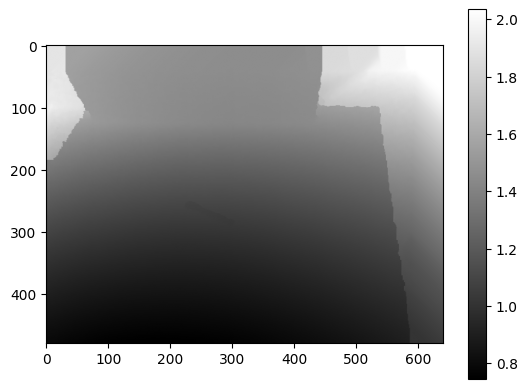

In [32]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio

depth_img = imageio.imread("./data/01/pcd0120d.tiff")
plt.imshow(depth_img, cmap='gray')
plt.colorbar()
plt.show()